## Change to desired working directory (if needed)

In [1]:
import os 
print("current working directory: ", os.getcwd())
os.chdir("/work/halld/home/dbarton/gluex/dselectors/")
print("changed directory to: ", os.getcwd())
print(os.listdir())

current working directory:  /w/halld-scshelf2101/home/dbarton/gluex/analysisMC
changed directory to:  /w/halld-scshelf2101/home/dbarton/gluex/dselectors
['KKpi_mc_flatte.root', 'runDSelectorSWIF2_ROOT_SCRIPT.C', 'gen_amp_V2_030274_000.root', 'DSelector_KKpi_mcThrown_C_ACLiC_dict_rdict.pcm', 'DSelector_DEBUGGING.ipynb', 'tempMC', 'DSelector_mc_pipkmks_thrown_C.d', 'DSelector_pi0kplamb_flat_C.so', 'runDSelectorSWIF2.csh', 'DSelector_KKpi_mc.C', 'DSelector_KKpi_mc_flatte.C', 'DSelector_OmegaKLambdaNew.C', 'forRichardJones', 'DSelector_pipkmks_flat_bestchi2.C', 'DSelector_pipkmks_flat_bestchi2_C.so', 'DSelector_unqiueTracking.C', 'DSelector_KKpi_mc_flatte_C.d', 'runDSelectorINTERACTIVE.cc', 'DSelector_KKpi_mcThrown_C.d', 'genr8_030738_000.ascii', 'runDSelectorSWIF2_S17.config', 'gen_amp_V2_030274_000.hddm', 'DSelector_KKpi_mc_flatte_C_ACLiC_dict_rdict.pcm', 'archive', 'DSelector_pipkmks_flat_bestchi2.h', 'tmp', 'DSelector_KKpi_mc_flatte.h', 'DSelector_KKpi_mc.h', 'runDSelectorSWIF2_tylerVe

## Create Dataframe \& list columns

In [16]:
import numpy as np
import ROOT
# ROOT.EnableImplicitMT() # Enable multi-threading
fileName = "/work/halld/home/dbarton/gluex/dselectors/KKpi_mc_flatte.root"
treeName = "pipkmks_flat_mc"

# Make dataframe from tree
def buildDataFrame(fileName, treeName):
    df = ROOT.RDataFrame(treeName, fileName)

    df = df.Define('kShort_E', 'pip2_E + pim_E') \
           .Define('kShort_px', 'pip2_px + pim_px') \
           .Define('kShort_py', 'pip2_py + pim_py') \
           .Define('kShort_pz', 'pip2_pz + pim_pz') \
           .Define('kShort_m', 'TMath::Sqrt(kShort_E*kShort_E - kShort_px*kShort_px - kShort_py*kShort_py - kShort_pz*kShort_pz)') \
           .Define('kShort_m2', 'kShort_E*kShort_E - kShort_px*kShort_px - kShort_py*kShort_py - kShort_pz*kShort_pz')

    return df

dfKKpi = buildDataFrame(fileName, treeName)

# List available columns for plotting
def list_trees_and_branches(filename):
    file = ROOT.TFile.Open(filename)
    # Loop over all keys in the file
    for key in file.GetListOfKeys():
        obj = key.ReadObj()
        # Check if the object is a tree
        if isinstance(obj, ROOT.TTree):
            tree = obj
            print(f"File: {filename}")
            print(f"Tree: {tree.GetName()}")
            print("Branches:")
            # List all branches in the tree
            branches = tree.GetListOfBranches()
            for branch in branches:
                print(f" - {branch.GetName()}")

    file.ls()
    file.Close()
list_trees_and_branches(fileName)


File: /work/halld/home/dbarton/gluex/dselectors/KKpi_mc_flatte.root
Tree: pipkmks_flat_mc
Branches:
 - run
 - event
 - weight
 - numtruepid_final
 - truepids_decay
 - is_truetop
 - is_truecombo
 - is_bdtcombo
 - rftime
 - kin_chisq
 - kin_ndf
 - beam_beamid
 - beam_isgen
 - beam_x4_meas
 - beam_p4_meas
 - beam_x4_kin
 - beam_p4_kin
 - beam_x4_true
 - beam_p4_true
 - pip1_trkid
 - pip1_x4_meas
 - pip1_p4_meas
 - pip1_x4_kin
 - pip1_p4_kin
 - pip1_true_fom
 - pip1_x4_true
 - pip1_p4_true
 - pip1_pid_fom
 - pip1_beta_time
 - pip1_chisq_time
 - pip1_ndf_time
 - pip1_ndf_trk
 - pip1_chisq_trk
 - pip1_ndf_dedx
 - pip1_chisq_dedx
 - pip1_dedx_cdc
 - pip1_dedx_fdc
 - pip1_dedx_tof
 - pip1_dedx_st
 - pip1_ebcal
 - pip1_eprebcal
 - pip1_efcal
 - pip1_bcal_delphi
 - pip1_bcal_delz
 - pip1_fcal_doca
 - km_trkid
 - km_x4_meas
 - km_p4_meas
 - km_x4_kin
 - km_p4_kin
 - km_true_fom
 - km_x4_true
 - km_p4_true
 - km_pid_fom
 - km_beta_time
 - km_chisq_time
 - km_ndf_time
 - km_ndf_trk
 - km_chisq_trk


## Define Cuts

In [3]:
# Define cuts

pathlength_sig = 'pathlength_sig > 5' # pathlength significance cut
reject_delta = 'delta_m > 1.4' # delta++ cut
reject_lambda = 'lambda_m > 1.9' # lambda cut
keep_kstar_plus = 'kspip1_m >= 0.8 && kspip1_m <= 1.0' # "charged" K*(KsPi+)
keep_kstar_zero = 'kmpip1_m >= 0.8 && kmpip1_m <= 1.0' # "neutral" K*(K-Pi+)
reject_kstar_plus = 'kspip1_m <= 0.8 || kspip1_m >= 1.0' # Reject "charged" K*(KsPi+)
reject_kstar_zero = 'kmpip1_m <= 0.8 || kmpip1_m >= 1.0' # Reject "neutral" K*(K-Pi+)
select_kShort = 'ks_m >= 0.30 && ks_m <= 0.80' # Select kShort
reject_kShort = 'ks_m <= 0.45 || ks_m >= 0.55' # Reject kShort
select_KKpi = 'KKpi_m >= 1.0 && KKpi_m <= 1.8' # Select KKpi



### -t slope (momentum transfer)

In [ ]:
from IPython.display import Image, display

def momentumTransfer(df):
    dfFiltered = df

    canvas = ROOT.TCanvas("canvas", "c1", 800, 600)

    h1 = dfFiltered.Histo1D(("men_t", "Momentum Transfer: -(dTargetP4 - locProtonP4).M2()", 100, 0, 1), "men_t")
    h1.SetLineColor(ROOT.kBlue)
    h1.SetStats(False)
    h1.GetXaxis().SetTitle("[GeV/c^{2}]")
    h1.Draw()

    # Define fit function for t-distribution
    exp = ROOT.TF1("exp", "TMath::Exp([0] + [1] * x + [2] * x * x)", 0.01, 2.0)
    exp.SetParName(0, "expPar0")
    exp.SetParName(1, "expPar1")
    exp.SetParName(2, "expPar2")
    
    # Set and/or fix parameters
    exp.SetParameter("expPar0", 0)
    exp.SetParameter("expPar1", 1)
    exp.SetParameter("expPar2", 0e+00)
    # exp.FixParameter(0, 0)
    # exp.FixParameter(1, 1.0)
    # exp.FixParameter(2, 1.0)
    h1.Fit("exp", "R")

    legend1 = ROOT.TLegend(0.62, 0.85, 0.90, 0.90) # xLeft, yBottom, xRight, yTop
    legend1.AddEntry(h1.GetValue(), "Momentum Transfer", "l")
    legend1.AddEntry(exp, "Expoential Fit", "l")
    legend1.Draw()

    canvas.Draw()

    img_path = "../_plotsMC/momentumTransfer.png"
    canvas.SaveAs(img_path)  # Saves the canvas as an image
    canvas.Close()

    display(Image(filename=img_path))

momentumTransfer(dfKKpi)


### Histogram - kShort

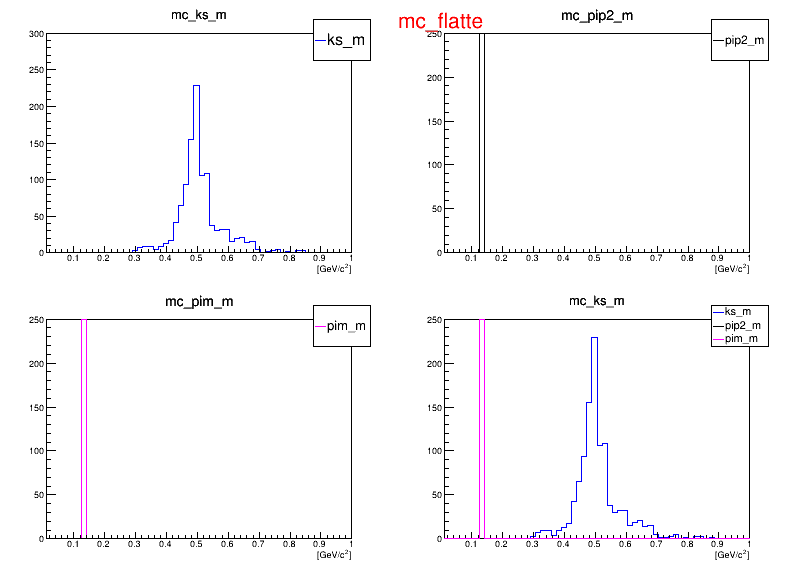

Info in <TCanvas::Print>: png file ../_plotsMC/mcKShort_flatte.png has been created


In [25]:
from IPython.display import Image, display

def analysis(df):

    ######## APPLY CUTS ########
    dfFiltered = df
    ############################

    min_height = 0
    max_height = 250

    canvas = ROOT.TCanvas("c1", "c1", 800, 600)
    canvas.Divide(2, 2)

    canvas.cd(1)
    h1 = dfFiltered.Histo1D(('kShort_m', 'mc_ks_m', 60, 0.01, 1.0), 'kShort_m') # arguments: (name, title, bins, min, max), columnVariable
    h1.SetLineColor(ROOT.kBlue)
    h1.SetMinimum(min_height)
    h1.SetMaximum(300)
    h1.SetStats(False)
    h1.GetXaxis().SetTitle('[GeV/c^{2}]')
    h1.Draw()
    legend1 = ROOT.TLegend(0.8, 0.80, 0.95, 0.95)
    legend1.AddEntry(h1.GetValue(), 'ks_m', 'l')
    legend1.Draw('same')

    canvas.cd(2)
    h2 = dfFiltered.Histo1D(('pip2_m', 'mc_pip2_m', 60, 0.01, 1.0), 'pip2_m')
    h2.SetLineColor(ROOT.kBlack)
    h2.SetMinimum(min_height)
    h2.SetMaximum(max_height)
    h2.SetStats(False)
    h2.GetXaxis().SetTitle('[GeV/c^{2}]')
    h2.Draw('same')
    legend2 = ROOT.TLegend(0.8, 0.80, 0.95, 0.95)
    legend2.AddEntry(h2.GetValue(), 'pip2_m', 'l')
    legend2.Draw('same')

    canvas.cd(3)
    h3 = dfFiltered.Histo1D(('pim_m', 'mc_pim_m', 60, 0.01, 1.0), 'pim_m')
    h3.SetLineColor(ROOT.kMagenta)
    h3.SetMinimum(min_height)
    h3.SetMaximum(max_height)
    h3.SetStats(False)
    h3.GetXaxis().SetTitle('[GeV/c^{2}]')
    h3.Draw('same')
    legend3 = ROOT.TLegend(0.8, 0.80, 0.95, 0.95)
    legend3.AddEntry(h3.GetValue(), 'pim_m', 'l')
    legend3.Draw('same')

    canvas.cd(4)
    h4 = dfFiltered.Histo1D(('kShort_m', 'mc_ks_m', 60, 0.01, 1.0), 'kShort_m')
    h4.SetLineColor(ROOT.kBlue)
    h4.SetMinimum(min_height)
    h4.SetMaximum(max_height)
    h4.SetStats(False)
    h4.GetXaxis().SetTitle('[GeV/c^{2}]')
    h4.Draw('same')
    h5 = dfFiltered.Histo1D(('pip2_m', 'mc_pip2_m', 60, 0.01, 1.0), 'pip2_m')
    h5.SetLineColor(ROOT.kBlack)
    h5.SetMinimum(min_height)
    h5.SetMaximum(max_height)
    h5.SetStats(False)
    h5.Draw('same')
    h6 = dfFiltered.Histo1D(('pim_m', 'mc_pim_m', 60, 0.01, 1.0), 'pim_m')
    h6.SetLineColor(ROOT.kMagenta)
    h6.SetMinimum(min_height)
    h6.SetMaximum(max_height)
    h6.SetStats(False)
    h6.Draw('same')
    legend4 = ROOT.TLegend(0.8, 0.80, 0.95, 0.95) # xLeft, yBottom, xRight, yTop
    legend4.AddEntry(h4.GetValue(), 'ks_m', 'l')
    legend4.AddEntry(h5.GetValue(), 'pip2_m', 'l')
    legend4.AddEntry(h6.GetValue(), 'pim_m', 'l')
    legend4.Draw('same')

    canvas.cd(0)
    title = ROOT.TLatex()
    title.SetNDC()
    title.SetTextFont(42)
    title.SetTextSize(0.04)
    title.SetTextColor(2)
    title.DrawLatex(0.5, 0.95, "mc_flatte")

    img_path = "../_plotsMC/mcKShort_flatte.png"
    canvas.SaveAs(img_path)  # Saves the canvas as an image
    canvas.Close()

    display(Image(filename=img_path))


analysis(dfKKpi)


### Histogram - KK $\pi$

In [ ]:
from IPython.display import Image, display

def plotting(df):
    
    ######## APPLY CUTS ########
    dfFiltered = df.Filter(reject_delta) #.Filter(reject_lambda) # .Filter(keep_kstar_plus).Filter(reject_kstar_zero).Filter(select_kShort).
    # dfFiltered = df.Filter(select_kShort)
    ############################

    canvas = ROOT.TCanvas("c", "c", 800, 600)
    h1 = dfFiltered.Histo1D(('KKpi_m', 'mcKKpi', 60, 1.2, 5.2), 'KKpi_m')
    h1.SetStats(False)
    h1.GetXaxis().SetTitle('[GeV/c^{2}]')
    h1.Draw()

    # create legend
    legend = ROOT.TLegend(0.15, 0.83, 0.22, 0.88) # xLeft, yBottom, xRight, yTop
    legend.AddEntry(h1.GetValue(), 'KKpi_m', 'l')
    legend.Draw('same')
    
    img_path = "../_plotsMC/mcKKpi.png"
    canvas.SaveAs(img_path)
    canvas.Close()

    # Display the saved image
    display(Image(filename=img_path))

plotting(dfKKpi)

### Dalitz Plots - (kShort  +  $\pi^{+}$) vs. (kMinus + $\pi^{+}$)

In [ ]:
from IPython.display import Image, display

def dalitzPlot(df):
    
    ######## APPLY CUTS ########
    dfFiltered = df #.Filter(pathlength_sig).Filter(select_KKpi)
    ############################

    h2 = dfFiltered.Histo2D(('DalitzPlot', 'DalitzPlot', 60, 0.1, 1.4, 60, 0.1, 1.4), 'kspip1_m2', 'kmpip1_m2')
    canvas = ROOT.TCanvas("c", "c", 800, 600)
    h2.SetStats(False)
    h2.Draw("colz")
    canvas.Update()
    
    img_path = "../_plotsMC/dalitzPlots/mcDalitzTEST.png"
    canvas.SaveAs(img_path)
    canvas.Draw()
    # canvas.Close()
    

    # # Display the saved image
    display(Image(filename=img_path))

dalitzPlot(dfKKpi)

## Fitting: define functions

In [ ]:
# Create various functions from 'ROOT' framework for fitting to histograms

# Breit-Wigner function
bw = ROOT.TF1("bw", "breitwigner(0)", 1.2, 1.7); # used to have BreitWigner(x, [4], [5])
# bw = ROOT.TF1("bw", "TMath::BreitWigner(x, [0], [1])", 0.4, 0.6)

# Exponential
exp = ROOT.TF1("exp", "TMath::Exp([0] + [1] * x + [2] * x * x)", 1.2, 1.7) # old c++ code defines this exponential as 'bkg'
exp.SetParName(0, "expPar1")
exp.SetParName(1, "expPar2")
exp.SetParName(2, "expPar3")

# Voigtian function
voigtian = ROOT.TF1("voigtian", "[0]*TMath::Voigt(x - [1], [2], [3])", 1.2, 1.7)
voigtian.SetParName(0, "voigtian_amplitude")
voigtian.SetParName(1, "voigtian_mean") # 'mean' is the offset that places the peak at the correct position, where we know the resonance to be.  It represents the particles mass.
voigtian.SetParName(2, "voigtian_sigma") # 'sigma' is the gaussian width (detector resolution)
voigtian.SetParName(3, "voigtian_width") # ?? 'width' is the lorentzian width (natural width of the particle) ??

# Voigtian with RooVoigtian
# ???

######## COMBINED FUNCTIONS ########

# Voigtian + Exponential(3 parameters)
voigtian_plus_exp = ROOT.TF1("voigt_plus_expo3", "voigtian + exp", 0.1, 1.8)
voigtian_plus_exp.SetParameter(0, 4.5E2)
voigtian_plus_exp.SetParameter(1, 1.45807E0)
voigtian_plus_exp.SetParameter(2, 1.0E-02)
voigtian_plus_exp.SetParameter(3, 3.81110E-06)
voigtian_plus_exp.SetParameter(4, -6.47E0)
voigtian_plus_exp.SetParameter(5, 9.29E0)
voigtian_plus_exp.SetParameter(6, -2.970E0)

## Fitting: plots

In [ ]:
# Change all my code to lazy execution, i.e. no functions, instead just put histos in a cell, then drawing, etc, in another cell

from IPython.display import Image, display

def fitting(df):
    
    ######## APPLY CUTS ########
    dfFiltered = df.Filter(keep_kstar_plus).Filter(reject_kstar_zero).Filter(select_kShort).Filter(pathlength_sig).Filter(reject_delta).Filter(reject_lambda)
    ############################

    canvas = ROOT.TCanvas("c", "c", 800, 600)
    h1 = dfFiltered.Histo1D(('KKpi_m', 'KKpi', 60, 1.0, 1.8), 'KKpi_m')
    h1.SetStats(False)
    h1.Fit(voigtian_plus_exp, "RV")
    h1.Draw()
    voigtian_plus_exp.Draw("same")
    
    img_path = "../_plotsMC/mcKKpi_FIT_TEST.png"
    canvas.SaveAs(img_path)
    canvas.Close()

    # Display the saved image
    display(Image(filename=img_path))

fitting(dfKKpi)